In [1]:
from skimage import io
from skimage.color import rgb2hsv
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label
from skimage import color
import cv2
from skimage.morphology import binary_closing, square
from pathlib import Path
from skimage.morphology import convex_hull_image
from skimage.morphology import binary_closing, remove_small_holes

In [14]:
def mask_img(img):
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (image.shape[1] // 1, image.shape[0] // 1))

    # Convert the image to HSV
    hsv_image = rgb2hsv(image)
    hue_img = hsv_image[:, :, 0]
    sat_img = hsv_image[:, :, 1]
    value_img = hsv_image[:, :, 2]
    print(hue_img.max())
    print(hue_img.min())
    print()
    print(sat_img.max())
    print(sat_img.min())
    print()
    print(value_img.max())
    print(value_img.min())
    # Define the range for blue color
    # These ranges can be adjusted depending on the shade of blue in the image
    lower_blue = np.array([0.4, 0.3, 0.15])
    upper_blue = np.array([0.65, 0.7, 1])

    # Create a binary mask for the blue color
    mask = (
        (hsv_image[:, :, 0] >= lower_blue[0])
        & (hsv_image[:, :, 0] <= upper_blue[0])
        & (hsv_image[:, :, 1] >= lower_blue[1])
        & (hsv_image[:, :, 1] <= upper_blue[1])
        & (hsv_image[:, :, 2] >= lower_blue[2])
        & (hsv_image[:, :, 2] <= upper_blue[2])
    )

    # Convert the mask to uint8 format
    mask = mask.astype(np.uint8) * 255

    kernel = square(35)
    closed_mask = binary_closing(mask, kernel).astype(np.uint8)
    closed_mask = cv2.morphologyEx(closed_mask, cv2.MORPH_OPEN, kernel)
    closed_mask = cv2.dilate(closed_mask, kernel, iterations=3) * 255

    return closed_mask, image


def simple_mask(mask):
    # print(closed_mask)
    # Calculate the number of pixels for 5% of the height of the image
    percent = 0.15
    height_percent = int(mask.shape[0] * percent)
    # Set the top 5% and bottom 5% of the mask to false (unmasked)
    if mask.max() == 255:
        if mask[:height_percent, :].max() == 255:
            mask[:height_percent] = 255

        if mask[-height_percent:, :].max() == 255:
            mask[-height_percent:, :] = 255
    return mask


def mask_rgb_blue(img):
    # Open the image
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (300, 200))

    # Convert image to numpy array
    # image_np = np.array(image)

    # Define the blue color range
    # This range may need to be adjusted depending on the exact color to mask
    blue_min = np.array([50, 60, 120], np.uint8)
    blue_max = np.array([170, 160, 195], np.uint8)

    # Create a mask where blue regions are set to 255 (white) and all others are 0 (black)
    # mask_blue = np.all(image >= blue_min, axis=-1) & np.all(image <= blue_max, axis=-1)
    mask_blue = np.logical_and(
        image[:, :, 2] > blue_min[2], image[:, :, 2] < blue_max[2]
    )

    mask_blue = mask_blue.astype(np.uint8) * 255  # Convert boolean to uint8 (0 or 255)
    kernel = square(5)
    # mask_blue = cv2.morphologyEx(mask_blue, cv2.MORPH_OPEN, kernel)
    mask_blue = binary_closing(mask_blue, kernel).astype(np.uint8) * 255

    return mask_blue, image

25
/home/psa_images/SemiF-AnnotationPipeline/data/semifield-developed-images/NC_2024-01-26/autosfm/downscaled_photos/NC_1706287335.jpg
0.9988095238095238
0.0

1.0
0.0

1.0
0.043137254901960784
255


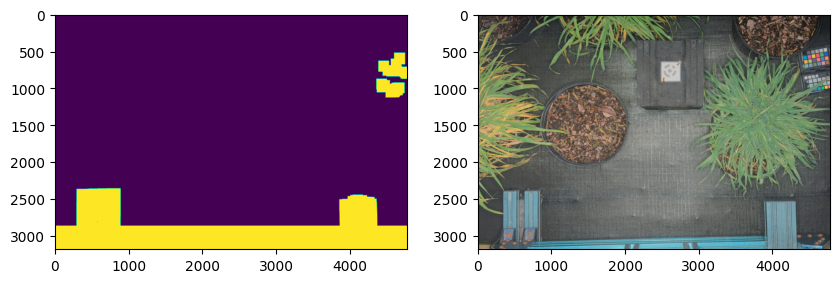

In [15]:
import random

# Load the image
path = Path(
    "/home/psa_images/SemiF-AnnotationPipeline/data/semifield-developed-images/NC_2024-01-26/autosfm/downscaled_photos"
)
imgs = list(path.glob("*.jpg"))
randint = random.randint(0, 1000)
randint = 25  # 25
print(randint)
random.seed(randint)
random.shuffle(imgs)
for img in imgs:
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    mask, image = mask_img(str(img))
    mask = simple_mask(mask)

    # mask, image = mask_rgb_blue(str(img))
    axs[0].imshow(mask, cmap="viridis")
    axs[1].imshow(image)
    # plt.imshow(mask)
    plt.show()
    break

In [ ]:
def generate_mask(img):
    img_red = img[:, :, 0]
    img_green = img[:, :, 1]
    img_blue = img[:, :, 2]
    img_exbrg = (
        -4.0 * img_green.astype(float)
        - 4.0 * img_red.astype(float)
        + 4.0 * img_blue.astype(float)
    )

    median = cv2.medianBlur((img_exbrg > -50).astype("uint8"), 19)
    median = cv2.medianBlur(median.astype("uint8"), 121)
    # median = ndimage.percentile_filter((img_exbrg>-40).astype('uint8'), percentile=50, size=20)

    kernel = np.ones((2700, 2700), np.uint8)  # np.ones((500, 900), np.uint8)
    img_dilated = cv2.dilate(median, kernel, iterations=1)

    img_connected_component = getLargestCC(img_dilated)

    # print(np.sum(img_connected_component))
    img_final = np.ones(img.shape[0:2])
    # if ((np.sum(img_connected_component)>2300000) and (np.sum(img_connected_component)<40000000)):
    if (np.sum(img_connected_component) > 1200000) and (
        np.sum(img_connected_component) < 40000000
    ):
        img_final[img_connected_component == 1] = 0

    #### ADDED weed frabric masking CODE ####
    img_hsv = color.rgb2hsv(img)
    median2 = cv2.medianBlur(((img_hsv[..., 1] * 255) < 55).astype("uint8"), 21)
    img_final[median2 == 1] = 0

    return img_final


def getLargestCC(segmentation):
    labels = label(segmentation)
    largestCC = labels == np.argmax(np.bincount(labels.flat, weights=segmentation.flat))
    return largestCC


from PIL import Image

path = "/home/psa_images/SemiF-AnnotationPipeline/data/semifield-developed-images/NC_2024-01-26/images/NC_1706281090.jpg"
img = Image.open(path)
width, height = img.size
image = np.asarray(img)
# image = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
mask = generate_mask(image)
plt.imshow(mask)
plt.show()

In [ ]:
np.unique(mask)